## Carga del dataset

Esta celda se encargará de bajar el dataset a vuestro ordenador. Tened en cuenta que puede haber fallos, ya que el repositorio de UCI desde donde se descarga tiene muchas peticiones simultáneas.

In [1]:
import os
import numpy as np
from scipy.special import erf
from scipy.io import loadmat
from tensorflow.keras.utils import get_file
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import regularizers




def download_dataset(directory):

    if not os.path.isdir(directory):
        os.makedirs(directory)

    filename = 'Isolet.mat'
    url = 'https://jundongl.github.io/scikit-feature/files/datasets/Isolet.mat'

    get_file(filename, url, cache_dir=directory, cache_subdir='.')


def load_dataset(directory=None):
    directory = directory or './isolet/'
    download_dataset(directory=directory)
    dataset = load_data(directory + 'Isolet.mat')
    return dataset


def load_data(source):
    dataset = loadmat(source)
    return dataset['X'].astype(float), dataset['Y'].astype(int)


In [2]:
# Cargamos el dataset
data, label = load_dataset()

# En esta línea estamos llamando a una función que tiene el propósito de cargar
# un dataset. Esta función puede ser una función personalizada (definida anteriormente en el código)
# o puede provenir de alguna librería que proporciona datasets de ejemplo (como `sklearn.datasets` o `tensorflow.keras.datasets`).

# La función `load_dataset()` devuelve dos objetos principales:
# - `data`: Este contiene las características o "features" del dataset, es decir,
#  los datos que se van a utilizar para entrenar el modelo. Normalmente es una matriz bidimensional,
#  donde cada fila representa una instancia o ejemplo del dataset, y cada columna representa una característica o atributo (también llamado "feature").
# - `label`: Este contiene las etiquetas o "targets" asociadas a cada instancia de `data`.
# Estas etiquetas son los valores que el modelo tratará de predecir. Pueden representar clases en un problema de clasificación o valores numéricos en un problema de regresión.

# Aquí, estamos desempaquetando el resultado de `load_dataset()` en dos variables:
# - `data`: Los datos o características.
# - `label`: Las etiquetas asociadas a esos datos.

# Por ejemplo, si estamos trabajando con un dataset de imágenes como MNIST, `data` podría contener imágenes
# en forma de matrices de píxeles, y `label` contendría los dígitos correspondientes (0-9) que representan las clases de esas imágenes.

# Otro ejemplo sería un dataset de reconocimiento de voz como ISOLET, donde `data` contendría características de audio
# (como coeficientes cepstrales de frecuencia melódica - MFCCs), y `label` contendría las letras del alfabeto asociadas a cada grabación.

# En este punto, no se sabe cómo se estructura exactamente `load_dataset()`,
# pero este paso es crucial para obtener los datos crudos que serán utilizados posteriormente para entrenar, validar o probar el modelo.

3652673/3652673 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Normalizamos los datos de entrada

Normaliza los datos de entrada de la manera que quieras, con el objetivo de facilitar el entrenamiento de la red. Recuerda que, si vas a utilizar valores estadísticos de los datos, éstos sólo pueden ser obtenidos de los datos de la partición de train. Es decir, **no se puede aplicar la función fit (o fit_transform) sobre los datos de validación o test**.

In [3]:
# Clase para normalizar los datos (normalizaremos por media 0 y varianza 1)
class Normalize:
    # Esta clase está diseñada para realizar la normalización de datos. La normalización
    # es un paso crucial en el preprocesamiento de datos, especialmente en machine learning,
    # porque asegura que todas las características (features) del dataset tengan un rango similar,
    # lo que puede mejorar la convergencia de los algoritmos de entrenamiento.

    def __init__(self):
        # El método '__init__' es el constructor de la clase. Este método se ejecuta cuando
        # creamos una instancia de la clase Normalize.
        # En este caso, inicializamos la variable 'self.stats' como None, que más tarde
        # contendrá las estadísticas necesarias (media y desviación estándar) para normalizar
        # los datos. 'self.stats' almacenará un diccionario con las estadísticas calculadas durante el ajuste.
        self.stats = None

    def fit(self, X):
        # El método 'fit' es utilizado para calcular las estadísticas necesarias para la normalización
        # a partir de los datos proporcionados en el argumento 'X'. En este caso, estamos calculando
        # la media y la desviación estándar a lo largo de las columnas del dataset, es decir,
        # para cada feature.

        # TODO: guarda las estadísticas de X necesarias para hacer la transformación

        # Aquí calculamos la media y desviación estándar para cada columna (o feature) de 'X'.
        # 'np.mean(X, axis=0)' calcula la media para cada columna (feature) del dataset 'X'.
        # 'np.std(X, axis=0)' hace lo mismo para la desviación estándar.
        # 'axis=0' significa que estamos operando a lo largo de las columnas, no de las filas.
        self.stats = {
            'mean': np.mean(X, axis=0),  # Media a lo largo de las columnas (features)
            'std': np.std(X, axis=0)     # Desviación estándar a lo largo de las columnas
        }
        # Devolvemos 'self' para permitir el encadenamiento de métodos, lo cual es una práctica común
        # en Python cuando se construyen pipelines de procesamiento de datos. Este patrón permite
        # llamar a métodos como 'normalizer.fit(data).transform(data)' de manera encadenada.
        return self

    def transform(self, X):
        # El método 'transform' transforma los datos proporcionados en 'X' usando las estadísticas
        # previamente calculadas en 'fit' (la media y la desviación estándar). El propósito es
        # transformar los datos para que tengan una media de 0 y una desviación estándar de 1.

        # TODO: transforma X para que tenga media 0 y varianza 1

        # Primero verificamos si 'self.stats' ha sido calculada. Si no se ha llamado al método 'fit'
        # previamente, entonces lanzamos un error porque no tenemos las estadísticas necesarias para
        # hacer la normalización.
        if self.stats is None:
            raise ValueError("Debe llamar a 'fit' antes de 'transform'.")

        # Esta línea realiza la normalización: restamos la media y dividimos por la desviación estándar
        # para cada feature. Esto da como resultado un dataset donde cada columna tiene media 0 y
        # desviación estándar 1, lo que asegura que todas las características tengan el mismo rango y
        # sean comparables.
        return (X - self.stats['mean']) / self.stats['std']

    def fit_transform(self, X):
        # El método 'fit_transform' combina las dos operaciones anteriores: 'fit' y 'transform'.
        # Es una optimización que se usa comúnmente en el preprocesamiento de datos porque ahorra
        # pasos cuando necesitamos ajustar el modelo a los datos y transformar esos mismos datos
        # en una sola llamada.

        # TODO: aplica fit y transform en la misma función

        # Primero, ajustamos las estadísticas llamando al método 'fit'.
        self.fit(X)

        # Luego, aplicamos la transformación a los datos normalizados.
        return self.transform(X)

## Diseña una función para crear tu propia red

Ya tienes los datos, es hora de hacer tu trabajo. Crea una función que te permita crear tu red en TensorFlow. Aunque el esqueleto que te proponemos abajo es una función sin parámetros, puedes poner tantos como quieras.

In [4]:
def crear_red(input_shape, num_classes, hidden_layers=[64, 32], activation='relu', optimizer='adam', loss='sparse_categorical_crossentropy'):
    """
    Crea una red neuronal con TensorFlow y Keras.

    Parámetros:
    - input_shape: tuple, tamaño de la entrada (número de características).
        * Este parámetro define la forma de los datos de entrada. Es una tupla que representa
          el número de características (o features) que tiene cada ejemplo en el conjunto de datos.
          Por ejemplo, si estamos trabajando con imágenes de 28x28 píxeles, el input_shape podría
          ser (784,) si aplanamos las imágenes, o (28, 28, 1) si las tratamos como imágenes 2D con un canal.

    - num_classes: int, número de clases para la salida.
        * Este parámetro define cuántas clases diferentes tiene el problema de clasificación.
          Por ejemplo, en un problema de clasificación de dígitos, donde las clases son los números del 0 al 9,
          num_classes sería 10.

    - hidden_layers: list, número de neuronas en cada capa oculta.
        * Este parámetro es una lista que define cuántas capas ocultas tendrá la red, y cuántas neuronas
          habrá en cada capa. Por ejemplo, hidden_layers=[64, 32] creará dos capas ocultas: la primera con 64 neuronas
          y la segunda con 32. Si quisieras una red más profunda, podrías aumentar el tamaño de esta lista.

    - activation: str, función de activación a usar en las capas ocultas.
        * Este es el tipo de función de activación que se aplicará en cada capa oculta de la red. La función de activación
          introduce no linealidades en la red, permitiendo que la red aprenda y modele relaciones complejas entre las
          entradas y las salidas. La función 'relu' (Rectified Linear Unit) es una de las más populares, ya que ayuda
          a mitigar el problema del gradiente desaparecido y mejora la convergencia del modelo.

    - optimizer: str, optimizador para el modelo.
        * Este parámetro define el algoritmo de optimización que se utilizará para actualizar los pesos de la red.
          'adam' es un optimizador basado en el descenso del gradiente, conocido por ser eficiente y rápido. Otros
          optimizadores como 'sgd' o 'rmsprop' podrían usarse, dependiendo del problema.

    - loss: str, función de pérdida para el modelo.
        * Esta es la función que mide qué tan bien se ajusta la predicción del modelo a la etiqueta real. En problemas
          de clasificación multiclase, 'sparse_categorical_crossentropy' es una opción común. Esta función se utiliza
          cuando las etiquetas son enteros (por ejemplo, 0, 1, 2, ... en vez de vectores one-hot). Para problemas
          de regresión o clasificación binaria, se podrían usar otras funciones de pérdida como 'mse' (Mean Squared Error)
          o 'binary_crossentropy'.

    Retorna:
    - modelo compilado de TensorFlow.
        * El método devuelve el modelo completamente definido y compilado, listo para ser entrenado en los datos.
    """

    # Inicializamos un modelo secuencial
    # Un modelo secuencial en Keras significa que las capas son apiladas una sobre otra de forma lineal,
    # lo cual es útil para la mayoría de los modelos de redes neuronales estándar.
    model = models.Sequential()

    # Añadimos la capa de entrada (input_shape)
    # La primera capa de la red, que define la forma de los datos de entrada. Esto es necesario para que
    # el modelo sepa qué dimensiones esperar al procesar el conjunto de datos.
    model.add(layers.InputLayer(input_shape=input_shape))

    # Añadimos las capas ocultas
    # Aquí se itera sobre la lista 'hidden_layers' que contiene el número de neuronas para cada capa oculta.
    # Para cada valor en la lista (que corresponde al número de neuronas en esa capa), se añade una capa densa (fully connected)
    # con el número de unidades especificadas y la función de activación (por defecto, 'relu').
    for units in hidden_layers:
        # layers.Dense crea una capa totalmente conectada (fully connected).
        # Esto significa que cada neurona de esta capa está conectada a cada neurona de la capa anterior.
        # 'units' define el número de neuronas en esta capa y 'activation' especifica la función de activación a usar.
        model.add(layers.Dense(units, activation=activation))

    # Añadimos la capa de salida
    # La capa de salida utiliza 'softmax' como función de activación. 'softmax' convierte las salidas
    # en probabilidades que suman 1, lo cual es útil en problemas de clasificación multiclase.
    # El número de neuronas en esta capa es igual al número de clases, porque estamos haciendo
    # clasificación multiclase. Cada neurona corresponde a una clase y su salida es la probabilidad de que
    # el ejemplo de entrada pertenezca a esa clase.
    model.add(layers.Dense(num_classes, activation='softmax'))  # softmax para clasificación multiclase

    # Compilamos el modelo con optimizador, función de pérdida y métrica
    # Aquí se especifica el optimizador, la función de pérdida y la métrica para evaluar el rendimiento del modelo.
    # 'optimizer' se encarga de actualizar los pesos del modelo durante el entrenamiento, mientras que
    # 'loss' mide qué tan bien el modelo se ajusta a los datos de entrenamiento. 'metrics' define
    # las métricas que queremos monitorear (en este caso, la precisión del modelo).
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    # Retornamos el modelo compilado listo para ser entrenado
    return model

## Entrena tus redes

Prueba a entrenar distintas configuraciones sobre los datos de entrenamiento, almacenando los resultados obtenidos de la precisión tanto en dicho conjunto como en el de validación.

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import numpy as np

# Definimos los parámetros del modelo
n_hidden_layers = 2 # Número de capas ocultas en la red. En este caso, estamos configurando 2 capas ocultas.
n_neurons = 50  # Número de neuronas en cada capa oculta. Aquí cada capa oculta tendrá 50 neuronas.
regularization = 0.01 # Valor de la regularización L2. Esto ayuda a prevenir el sobreajuste penalizando los pesos grandes.
activation = 'relu' # La función de activación que se aplicará en las capas ocultas. 'relu' es comúnmente usada en redes profundas.
k_values = [3, 5, 10]

# Crear el modelo
def crear_modelo_tf(input_shape, num_classes):
    """
    Función que crea y compila un modelo secuencial de TensorFlow usando Keras.

    Parámetros:
    - input_shape: tupla que indica el tamaño de la entrada (el número de características o dimensiones de los datos).
    - num_classes: número de clases en el conjunto de etiquetas (problema de clasificación multiclase).

    Retorna:
    - Un modelo de Keras compilado listo para entrenarse.
    """
    # Inicializamos un modelo secuencial
    model = tf.keras.models.Sequential()

    # Añadimos la capa de entrada especificando el input_shape.
    # La capa de entrada define el formato de los datos de entrada. Es crucial para que la red sepa cómo debe ser la forma
    # del input (cuántas características tiene cada ejemplo).
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Añadir capas ocultas
    # Aquí iteramos sobre el número de capas ocultas definido en 'n_hidden_layers'.
    # Cada capa será densa (fully connected) con el número de neuronas definido en 'n_neurons' y usará la activación ReLU.
    # También se aplica regularización L2 a cada capa, lo que significa que se añade una penalización al coste
    # basado en la magnitud de los pesos de la capa, para ayudar a prevenir el sobreajuste.
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation,
                                        kernel_regularizer=regularizers.l2(regularization)))

    # Añadir la capa de salida
    # Esta es la última capa de la red. Dado que estamos realizando clasificación multiclase, usamos 'softmax'
    # como función de activación para que las salidas se interpreten como probabilidades para cada clase.
    # El número de neuronas en la capa de salida es igual al número de clases 'num_classes', ya que cada neurona
    # corresponde a una clase diferente.
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compilamos el modelo
    # El modelo se compila especificando:
    # 1. El optimizador: 'adam', que es un optimizador eficiente para muchas tareas de machine learning.
    # 2. La función de pérdida: 'sparse_categorical_crossentropy', que se utiliza para problemas de clasificación
    #    multiclase cuando las etiquetas son enteros en lugar de vectores one-hot.
    # 3. Las métricas: en este caso, usamos 'accuracy' para medir qué tan precisa es la clasificación del modelo.
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Devolvemos el modelo ya compilado
    return model

# Normalizar los datos (usando la clase Normalize definida previamente)
# La normalización es importante porque ayuda a que las redes neuronales entrenen más rápido y de manera más estable.
# Aquí aplicamos la clase 'Normalize', que ajusta los datos para que tengan media 0 y varianza 1.
normalize = Normalize()
data_normalized = normalize.fit_transform(data) # Ajustamos los datos con 'fit' y luego los transformamos.

# Ajustar las etiquetas
# Las etiquetas en un problema de clasificación deben estar en el rango de [0, num_classes-1].
# Si por alguna razón las etiquetas empiezan en 1 en lugar de 0, necesitamos restar 1 a todas las etiquetas para que
# estén en el rango adecuado. 'flatten()' aplana las etiquetas en caso de que estén en una forma multidimensional.
label = label.flatten() - 1  # Aquí aseguramos que las etiquetas están en el rango [0, num_classes-1].

# Definir el input_shape y el número de clases
# 'input_shape' representa la cantidad de características en los datos de entrada. Para obtener esta información,
# usamos 'data_normalized.shape[1]' que nos da el número de columnas (características) en el dataset.
# 'num_classes' es el número total de clases que se están clasificando, lo cual obtenemos contando los valores únicos
# en las etiquetas (usamos 'np.unique(label)').
input_shape = (data_normalized.shape[1],) # El input_shape es una tupla que contiene el número de características.
num_classes = len(np.unique(label)) # Calculamos el número de clases únicas a partir de las etiquetas.

# Función para realizar K-fold cross-validation
def k_fold_cross_validation(k, data, label):
    kfold = KFold(n_splits=k, shuffle=True, random_state=1234)
    fold_accuracies = []

    for train_index, test_index in kfold.split(data):
        x_train, x_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        model = crear_modelo_tf(input_shape=input_shape, num_classes=num_classes)
        history = model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        fold_accuracies.append(accuracy)

    avg_accuracy = np.mean(fold_accuracies)
    print(f"Precisión promedio para k={k}: {avg_accuracy:.4f}")

# Llamar a la función para realizar K-fold cross-validation
for k in k_values:
    k_fold_cross_validation(k, data_normalized, label)

'''# Crear el modelo
# Usamos la función 'crear_modelo_tf' para crear el modelo de acuerdo a las especificaciones previas.
model = crear_modelo_tf(input_shape=input_shape, num_classes=num_classes)


# Entrenar el modelo
# 'model.fit' entrena el modelo en los datos normalizados con las etiquetas.
# Aquí se especifican:
# - data_normalized: los datos de entrada ya normalizados.
# - label: las etiquetas ajustadas.
# - epochs: cuántas veces el modelo verá el conjunto de datos completo (100 en este caso).
# - batch_size: cuántos ejemplos se procesarán a la vez en cada paso (aquí 100).
# - verbose: controla el nivel de información que se imprime durante el entrenamiento. '2' imprime por época.
history = model.fit(data_normalized, label, epochs=100, batch_size=100, verbose=2)

# Evaluar el modelo en los datos de entrenamiento
# Después de entrenar el modelo, evaluamos su rendimiento en los datos de entrenamiento usando 'model.evaluate'.
# Devuelve la pérdida y la precisión del modelo.
train_loss, train_accuracy = model.evaluate(data_normalized, label, verbose=1)

# Mostrar los resultados
# Imprimimos la precisión del modelo en el conjunto de entrenamiento usando 'train_accuracy'.
# Formateamos el resultado para que tenga cuatro decimales.
print(f"Precisión del modelo en el conjunto de entrenamiento: {train_accuracy:.4f}")'''



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Precisión promedio para k=3: 0.9494
Precisión promedio para k=5: 0.9519
Precisión promedio para k=10: 0.9551


'# Crear el modelo\n# Usamos la función \'crear_modelo_tf\' para crear el modelo de acuerdo a las especificaciones previas.\nmodel = crear_modelo_tf(input_shape=input_shape, num_classes=num_classes)\n\n\n# Entrenar el modelo\n# \'model.fit\' entrena el modelo en los datos normalizados con las etiquetas.\n# Aquí se especifican:\n# - data_normalized: los datos de entrada ya normalizados.\n# - label: las etiquetas ajustadas.\n# - epochs: cuántas veces el modelo verá el conjunto de datos completo (100 en este caso).\n# - batch_size: cuántos ejemplos se procesarán a la vez en cada paso (aquí 100).\n# - verbose: controla el nivel de información que se imprime durante el entrenamiento. \'2\' imprime por época.\nhistory = model.fit(data_normalized, label, epochs=100, batch_size=100, verbose=2)\n\n# Evaluar el modelo en los datos de entrenamiento\n# Después de entrenar el modelo, evaluamos su rendimiento en los datos de entrenamiento usando \'model.evaluate\'.\n# Devuelve la pérdida y la precis

In [6]:
import json
n_splits = 3 # Definimos el número de splits (divisiones) para el K-fold cross-validation.
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Inicializamos K-fold cross-validation con 3 splits.
# shuffle=True baraja aleatoriamente los datos antes de dividirlos y random_state asegura la reproducibilidad.

# Parámetros a probar
activations = ['relu', 'tanh']  # Lista de funciones de activación que vamos a probar en las capas ocultas.
regularizations = [0.0001, 0.1]  # Valores de regularización L2 que probaremos para penalizar los pesos grandes.
hidden_layer_elements_list = [10, 100]  # Número de neuronas por capa oculta en cada configuración.
n_hidden_layers_list = [1, 5]  # Número de capas ocultas a probar en cada configuración.

# Función para crear el modelo
def crear_modelo(input_shape, num_classes, n_hidden_layers, n_neurons, activation, regularization):
    """
    Crea y compila un modelo secuencial con TensorFlow y Keras.

    Parámetros:
    - input_shape: tupla, tamaño de la entrada (número de características).
    - num_classes: int, número de clases para la salida.
    - n_hidden_layers: int, número de capas ocultas a añadir.
    - n_neurons: int, número de neuronas en cada capa oculta.
    - activation: str, función de activación a usar en las capas ocultas.
    - regularization: float, valor de la regularización L2.

    Retorna:
    - Un modelo compilado de TensorFlow.
    """
    # Inicializamos un modelo secuencial
    model = tf.keras.models.Sequential()

    # Añadimos la capa de entrada especificando el tamaño de la entrada
    # Esto indica cuántas características tiene cada ejemplo de entrada.
    model.add(tf.keras.layers.InputLayer(shape=input_shape))


    # Añadir capas ocultas
    # Iteramos sobre el número de capas ocultas especificado en n_hidden_layers.
    # En cada iteración, añadimos una capa densa (fully connected) con n_neurons neuronas,
    # la función de activación (activation) y la regularización L2.
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation,
                                        kernel_regularizer=regularizers.l2(regularization)))

    # Añadir capa de salida
    # La última capa es densa y tiene num_classes neuronas (una por cada clase).
    # Usamos 'softmax' para obtener probabilidades de clasificación multiclase.
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compilar el modelo
    # Usamos 'adam' como optimizador, 'sparse_categorical_crossentropy' como función de pérdida
    # (adecuada para problemas de clasificación multiclase con etiquetas enteras),
    # y 'accuracy' como métrica para evaluar el rendimiento del modelo.
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Devolvemos el modelo ya compilado
    return model

# Para almacenar los resultados de cada configuración de modelo
results = []

# Ajuste de las etiquetas (aseguramos que las etiquetas están en el rango correcto)
# Aquí, ajustamos las etiquetas para que comiencen desde 0, ya que 'sparse_categorical_crossentropy' requiere
# que las etiquetas estén entre 0 y num_classes-1.
label = label.flatten() - label.min()


# Iterar sobre todas las combinaciones posibles de parámetros
# Aquí, estamos probando todas las combinaciones posibles de:
# - n_hidden_layers: número de capas ocultas.
# - n_neurons: número de neuronas por capa.
# - regularization: valor de la regularización L2.
# - activation: función de activación (relu o tanh).
for n_hidden_layers in n_hidden_layers_list:
    for n_neurons in hidden_layer_elements_list:
        for regularization in regularizations:
            for activation in activations:

                # Listas para almacenar las precisiones de entrenamiento y validación de cada fold
                train_accuracies = []
                val_accuracies = []

                # Dividimos los datos en train y validation usando KFold cross-validation
                for train_index, val_index in kf.split(data):
                    X_train, X_val = data[train_index], data[val_index] # Dividimos los datos en conjuntos de entrenamiento y validación.
                    y_train, y_val = label[train_index], label[val_index] # Dividimos las etiquetas correspondientes.

                    # Crear y entrenar el modelo con la configuración actual
                    model = crear_modelo(input_shape=(data.shape[1],), # El número de características del dataset.
                                         num_classes=len(np.unique(label)), # Número de clases.
                                         n_hidden_layers=n_hidden_layers, # Número de capas ocultas a usar.
                                         n_neurons=n_neurons, # Número de neuronas por capa oculta.
                                         activation=activation, # Función de activación a usar.
                                         regularization=regularization) # Valor de la regularización L2.

                    # Entrenamos el modelo con los datos de entrenamiento y lo validamos con los datos de validación
                    # Utilizamos 10 épocas y un batch_size de 32 para entrenamiento.
                    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

                    # Guardar las precisiones de entrenamiento y validación del último epoch
                    train_acc = history.history['accuracy'][-1] # Precisión de entrenamiento en la última época.
                    val_acc = history.history['val_accuracy'][-1] # Precisión de validación en la última época.

                    # Añadimos las precisiones a las listas correspondientes
                    train_accuracies.append(train_acc)
                    val_accuracies.append(val_acc)

                # Promediar las precisiones de entrenamiento y validación para los folds de K-Fold
                avg_train_acc = np.mean(train_accuracies) # Media de las precisiones de entrenamiento.
                avg_val_acc = np.mean(val_accuracies) # Media de las precisiones de validación.

                # Guardar los resultados de la configuración
                results.append({
                    'n_hidden_layers': n_hidden_layers,
                    'n_neurons': n_neurons,
                    'regularization': regularization,
                    'activation': activation,
                    'avg_train_acc': avg_train_acc,
                    'avg_val_acc': avg_val_acc
                })

# Buscar el mejor y el peor modelo basado en la precisión de validación
best_model = max(results, key=lambda x: x['avg_val_acc'])
worst_model = min(results, key=lambda x: x['avg_val_acc'])

# Mostrar el mejor modelo
print(f"Mejor modelo - Capas ocultas: {best_model['n_hidden_layers']}, Neuronas: {best_model['n_neurons']}, "
      f"Regularización: {best_model['regularization']}, Activación: {best_model['activation']}, "
      f"Precisión en entrenamiento: {best_model['avg_train_acc']:.4f}, Precisión en validación: {best_model['avg_val_acc']:.4f}")

# Mostrar el peor modelo
print(f"Peor modelo - Capas ocultas: {worst_model['n_hidden_layers']}, Neuronas: {worst_model['n_neurons']}, "
      f"Regularización: {worst_model['regularization']}, Activación: {worst_model['activation']}, "
      f"Precisión en entrenamiento: {worst_model['avg_train_acc']:.4f}, Precisión en validación: {worst_model['avg_val_acc']:.4f}")

# Mostrar los resultados
# for result in results:
    # print(f"Hidden Layers: {result['n_hidden_layers']}, Neurons per Layer: {result['n_neurons']}, "
          # f"Regularization: {result['regularization']}, Activation: {result['activation']}, "
          # f"Train Accuracy: {result['avg_train_acc']:.4f}, Validation Accuracy: {result['avg_val_acc']:.4f}")

# Guardar resultados en un archivo JSON
# Escribimos los resultados obtenidos en un archivo JSON para que puedan ser analizados posteriormente.
with open('training_results.json', 'w') as f:
    json.dump(results, f)

Mejor modelo - Capas ocultas: 1, Neuronas: 100, Regularización: 0.0001, Activación: relu, Precisión en entrenamiento: 0.9888, Precisión en validación: 0.9404
Peor modelo - Capas ocultas: 5, Neuronas: 10, Regularización: 0.1, Activación: tanh, Precisión en entrenamiento: 0.0913, Precisión en validación: 0.0731


## Visualiza los resultados

Muestra [gráficas 3D](https://matplotlib.org/stable/gallery/mplot3d/surface3d.html) con la precisión en el conjunto de validación sobre siguientes ejes:

* **Regularización** vs **Número de capas**
* **Regularización** vs **Número de unidades por capa**
* **Número de capas** vs **Número de unidades por capa**

Para los parámetros no incluídos en los ejes, utiliza aquellos obtenidos que han obtenido la mejor precisión en el conjunto de validación. Razona los resultados obtenidos. ¿Qué crees que está causando la fluctuación en los resultados obtenidos?

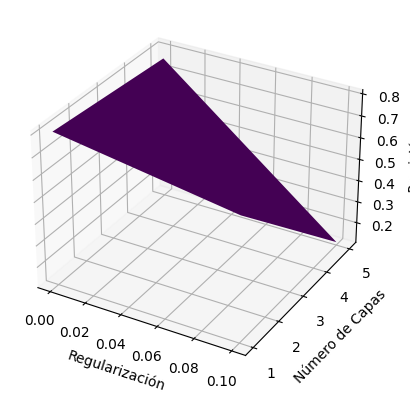

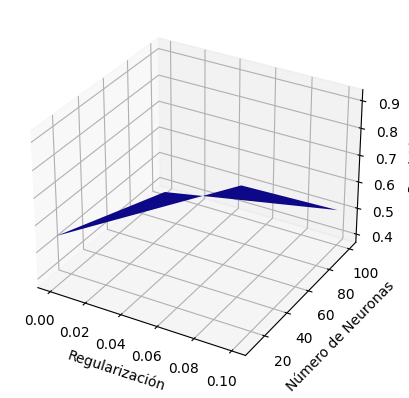

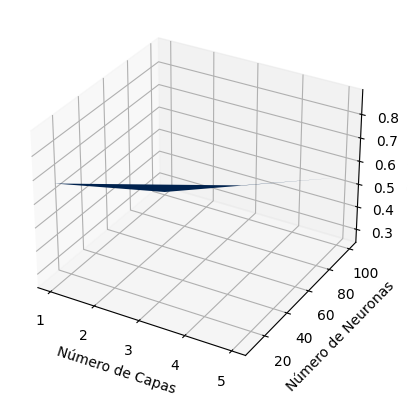

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json

# Cargar resultados del archivo JSON
with open('training_results.json', 'r') as f:
    results = json.load(f)

# Preparar arrays para las gráficas
regularizations = sorted(list(set([r['regularization'] for r in results])))
n_layers = sorted(list(set([r['n_hidden_layers'] for r in results])))
n_neurons = sorted(list(set([r['n_neurons'] for r in results])))

# Crear una función genérica para evitar repeticiones en las gráficas
def plot_3d_graph(X, Y, Z, x_label, y_label, z_label, cmap='viridis'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Crear la malla para los ejes
    X, Y = np.meshgrid(X, Y)

    # Gráfica de superficie
    ax.plot_surface(X, Y, Z, cmap=cmap)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

    plt.show()

# 1. Gráfica de Regularización vs Número de Capas
# Crear la matriz de precisiones para las combinaciones de regularización y número de capas
precisions = np.zeros((len(regularizations), len(n_layers)))
for i, reg in enumerate(regularizations):
    for j, n_layer in enumerate(n_layers):
        filtered_results = [r['avg_val_acc'] for r in results if r['regularization'] == reg and r['n_hidden_layers'] == n_layer]
        if filtered_results:
            precisions[i, j] = np.mean(filtered_results)

plot_3d_graph(regularizations, n_layers, precisions, 'Regularización', 'Número de Capas', 'Precisión')

# 2. Gráfica de Regularización vs Número de Neuronas por Capa
# 2. Gráfica de Regularización vs Número de Neuronas por Capa
precisions_neurons = np.zeros((len(regularizations), len(n_neurons)))
for i, reg in enumerate(regularizations):
    for j, n_neuron in enumerate(n_neurons):
        filtered_results = [r['avg_val_acc'] for r in results if r['regularization'] == reg and r['n_neurons'] == n_neuron]
        if filtered_results:
            precisions_neurons[i, j] = np.mean(filtered_results)


# 3. Gráfica de Número de Capas vs Número de Neuronas por Capa
precisions_layers_neurons = np.zeros((len(n_layers), len(n_neurons)))
for i, n_layer in enumerate(n_layers):
    for j, n_neuron in enumerate(n_neurons):
        filtered_results = [r['avg_val_acc'] for r in results if r['n_hidden_layers'] == n_layer and r['n_neurons'] == n_neuron]
        if filtered_results:
            precisions_layers_neurons[i, j] = np.mean(filtered_results)

plot_3d_graph(n_layers, n_neurons, precisions_layers_neurons, 'Número de Capas', 'Número de Neuronas', 'Precisión', cmap='cividis')


